In [1]:
import math
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 14,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

sigma, r, T, S_0, K = 0.3, 0.05, 2, 50.0, 52.0
Ns = [12, 52, 252]

In [2]:
# (a) Compute u, d, and p.
def crr(sigma: float, r: float, dt: float) -> tuple[float, float, float]:
    u = math.exp(sigma * math.sqrt(dt))
    d = math.exp(-sigma * math.sqrt(dt))
    p = (math.exp(r * dt) - d) / (u - d)
    return u, d, p

for N, delta_t in zip(Ns, ["1 month", "1 week", "1 day"]):
    u, d, p = crr(sigma, r, 1 / N)
    print(f"Δt = {delta_t:<7} u: {u:.9f}, d: {d:.9f}, p: {p:.9f}")

Δt = 1 month u: 1.090463178, d: 0.917041510, p: 0.502439228
Δt = 1 week  u: 1.042480026, d: 0.959250993, p: 0.501159348
Δt = 1 day   u: 1.019077925, d: 0.981279228, p: 0.500525300


In [3]:
# (b) Compute the European put price with N = 12, 52, and 252.
def european_put_binomial(S_0: float, K: float, T: float, r: float, sigma: float, N: int) -> float:
    dt = T / N
    u, d, p = crr(sigma, r, dt)
    disc = math.exp(-r * dt)
    
    prices = [S_0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]
    values = [max(K - s, 0.0) for s in prices]
    
    for n in range(N - 1, -1, -1):
        values = [disc * (p * values[j + 1] + (1 - p) * values[j]) for j in range(n + 1)]
    
    return values[0]

def european_put_blackscholes(S0: float, K: float, T: float, r: float, sigma: float) -> float:
    d1 = (math.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return K * math.exp(-r * T) * scipy.stats.norm.cdf(-d2) - S0 * scipy.stats.norm.cdf(-d1)

blackscholes = european_put_blackscholes(S_0, K, T, r, sigma)
print(f"Black-Scholes: {blackscholes:.9f}")

for N, delta_t in zip(Ns, ["1 month", "1 week", "1 day"]):
    put_binom = european_put_binomial(S_0, K, T, r, sigma, N * T)
    print(f"Δt = {delta_t:<7} Binomial: {put_binom:.9f} Difference: {abs(put_binom - blackscholes):.9f}")

Black-Scholes: 6.760140374
Δt = 1 month Binomial: 6.787398740 Difference: 0.027258366
Δt = 1 week  Binomial: 6.777474069 Difference: 0.017333695
Δt = 1 day   Binomial: 6.757001112 Difference: 0.003139262


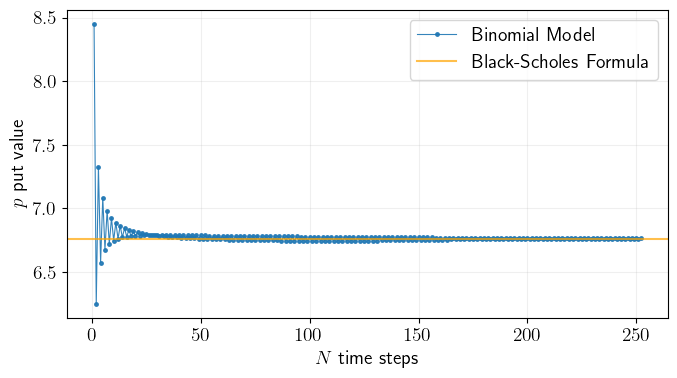

In [4]:
# (c) Compute the European put price with N = 1, 2, ..., 252.

for N in range(1, 253):
    if N == 1:
        N_grid = []
        put_series = []

    put_binom = european_put_binomial(S_0, K, T, r, sigma, N)
    N_grid.append(N)
    put_series.append(put_binom)

    # plot at the end of the sweep using dot markers to show oscillations clearly
    if N == 252:
        plt.figure(figsize=(7, 4))
        ax = plt.gca()
        ax.plot(N_grid, put_series, '.-', markersize=5, linewidth=0.8, color='C0', alpha=0.9, label='Binomial Model')
        ax.axhline(y=blackscholes, color='orange', linewidth=1.5, alpha=0.7, label='Black-Scholes Formula')
        ax.set_xlabel('$N$ time steps')
        ax.set_ylabel('$p$ put value')
        # ax.set_title('The Price of an European Put: the Binomial Model and the Black-Scholes Formula')
        ax.grid(True, alpha=0.2)
        ax.legend()
        plt.tight_layout()
        plt.savefig('figures/binomial_put_convergence_scatter.png', dpi=600, transparent=True)

In [5]:
# (d) Compute the American put price with N = 12, 52, and 252.

def american_put_binomial(S_0: float, K: float, T: float, r: float, sigma: float, N: int) -> float:
    dt = T / N
    u, d, p = crr(sigma, r, dt)
    disc = math.exp(-r * dt)

    prices_T = [S_0 * (u ** j) * (d ** (N - j)) for j in range(N + 1)]
    values = [max(K - s, 0.0) for s in prices_T]

    for n in range(N - 1, -1, -1):
        prices_n = [S_0 * (u ** j) * (d ** (n - j)) for j in range(n + 1)]
        continuation = [disc * (p * values[j + 1] + (1 - p) * values[j]) for j in range(n + 1)]
        exercise = [max(K - prices_n[j], 0.0) for j in range(n + 1)]
        values = [max(exercise[j], continuation[j]) for j in range(n + 1)]

    return values[0]

for N, delta_t in zip(Ns, ["1 month", "1 week", "1 day"]):
    total_steps = N * T
    am_put = american_put_binomial(S_0, K, T, r, sigma, total_steps)
    print(f"Δt = {delta_t:<7} American: {am_put:.9f}")

Δt = 1 month American: 7.507540313
Δt = 1 week  American: 7.485586439
Δt = 1 day   American: 7.471032189


<Figure size 640x480 with 0 Axes>

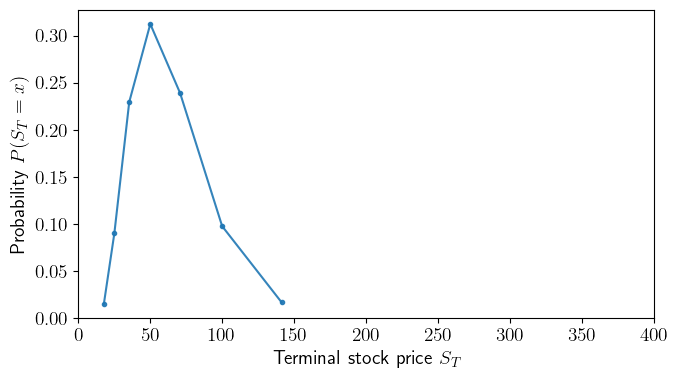

<Figure size 640x480 with 0 Axes>

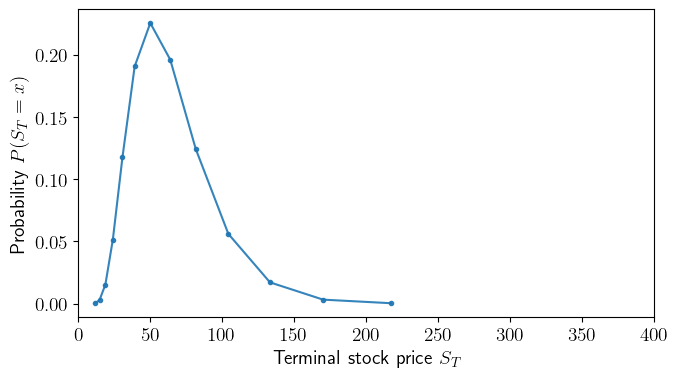

<Figure size 640x480 with 0 Axes>

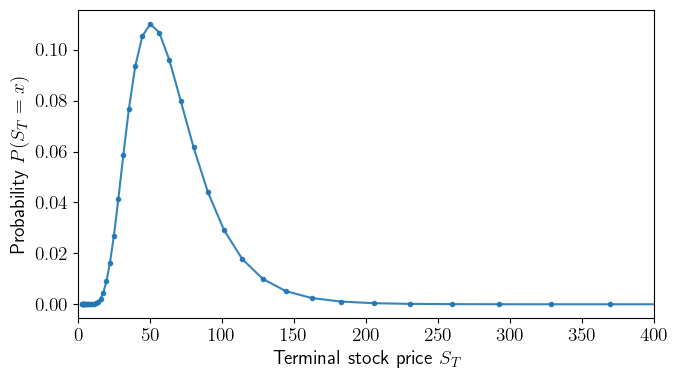

In [9]:
# Bonus: Compute the terminal stock prices and the corresponding probabilities for N = 6, 12, 52.


def terminal_distribution(S_0: float, r: float, sigma: float, T: float, N: int) -> pd.DataFrame:
    dt = T / N
    u, d, p = crr(sigma, r, dt)
    j = np.arange(N + 1)
    prices = S_0 * (u ** j) * (d ** (N - j))
    probs = np.array([math.comb(N, int(k)) * (p ** k) * ((1 - p) ** (N - k)) for k in j], dtype=float)
    probs = probs / probs.sum()
    df = pd.DataFrame({
        "S_T": prices,
        "Probability": probs
    })
    return df

for N in [6, 12, 52]:
    df  = terminal_distribution(S_0, r, sigma, T, N)
    plt.figure()
    plt.figure(figsize=(7, 4))
    ax = plt.gca()
    ax.cla()
    ax.plot(df["S_T"], df["Probability"], '.-', color='C0', alpha=0.9)
    ax.set_xlim(0, 400)
    ax.set_xlabel("Terminal stock price $S_T$")
    ax.set_ylabel(f"Probability $P(S_T = x)$")
    plt.tight_layout()
    plt.savefig(f'figures/binomial_terminal_distribution_N={N}.png', dpi=600, transparent=True)